# 5. Analysis of Exchange Pattern

In [20]:
import pandas as pd
import pickle
import numpy as np
# Plot the relationship between genres
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from func import get_relationship, relationship_with_name, plot_relationship, plot_relationship_with_t
import scipy.stats

## 1. Load the Reddit Data
paris_dense is the confirmed transaction data with time from Rappaz et. al (2017).

In [21]:
pair_time = pd.read_csv('./data/pairs_dense.csv',names=['user1','game1','user2','game2','time'])
pair_time['time'] = pd.to_datetime(pair_time['time'],unit='s')
pair_time = pair_time.loc[pair_time['time']>='2000-01-01']

In [22]:
# Load the gameswap transaction data with col names ['user1','game1','user2','game2']
pair = pd.read_csv('./data/pairs.csv', names=['user1','game1','user2','game2'])
# Load have and wish data
have = pd.read_csv('./data/have.csv', names=['user','game'])
wish = pd.read_csv('./data/wish_dense.csv', names=['user','game'])
# Load the games data we get from IGDB
games = pd.read_csv('./data/games_tbp.csv', index_col=0)
# Add a column of index with name 'game_id', second column
games.insert(1, 'game_id', range(0, len(games)))
games_genres = games[['game_id', 'genres']]

In [23]:
# Outer join have and wish on user
have_wish = have.merge(wish, on='user', how='outer', suffixes=['1','2']).astype('Int64')
print(have_wish.shape)

(332258, 3)


In [24]:
have_wish_cleaned = have_wish.dropna()
have_wish_relationship = get_relationship(have_wish_cleaned, games_genres, have_wish=True)

confirmed_relationship = get_relationship(pair, games_genres)

## 2. Plot the relationship
The detailed information about the games is obtained using IGDB.


In [25]:
with open('data/genres_igdb.pkl','rb') as f:
    genres_names = pickle.load(f)[['id','name']]
df_console_genres_count = pd.read_pickle('./data/genres_count_total.pkl')

In [26]:
confirmed = relationship_with_name(confirmed_relationship, genres_names, have_wish=False)

/home/jliu/project/func.py:92: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  relationship_syn = relationship_genres.pivot('name_1','name_2','count')


In [27]:
confirmed.apply(lambda x: sum(x), axis=1).sort_values(ascending=False)

name_1
Adventure                     3744.0
Role-playing (RPG)            2777.0
Shooter                       1694.0
Platform                      1459.0
Strategy                       613.0
Puzzle                         536.0
Turn-based strategy (TBS)      500.0
Hack and slash/Beat 'em up     463.0
Fighting                       391.0
Racing                         381.0
Simulator                      370.0
Tactical                       296.0
Sport                          281.0
Arcade                         205.0
Visual Novel                    96.0
Real Time Strategy (RTS)        85.0
Point-and-click                 73.0
Indie                           67.0
Card & Board Game               63.0
Music                           36.0
Pinball                          7.0
Quiz/Trivia                      6.0
dtype: float64

In [28]:
# Choose the genres that have more than 100 transactions.
confirmed_filtered = confirmed.loc[confirmed.apply(lambda x: x.sum(), axis=1).sort_values(ascending=False)>=100,confirmed.apply(lambda x: x.sum(), axis=1).sort_values(ascending=False)>=100]

In [29]:
genres_filtered = genres_names[genres_names['name'].isin(confirmed_filtered.index)]

In [30]:
df_console_genres_count = df_console_genres_count.loc[df_console_genres_count['name_total'].isin(confirmed_filtered.index)][['name_console','count_console']]
df_console_genres_count['percent'] = df_console_genres_count['count_console']/df_console_genres_count['count_console'].sum()*100

In [31]:
relationship_confirmed = relationship_with_name(confirmed_relationship, genres_names=genres_filtered, have_wish=False)
relationship_have_wish = relationship_with_name(have_wish_relationship, genres_names=genres_filtered, have_wish=True)

genres_confirmed = relationship_confirmed.columns
genres_have_wish = relationship_have_wish.columns

# Expand the relationship_confirmed and relationship_have_wish to the same size
relationship_confirmed = relationship_confirmed.reindex(index=relationship_have_wish.index, columns=relationship_have_wish.columns, fill_value=0)

# Normalize the relationship_confirmed and relationship_have_wish, they are symmetric
relationship_confirmed_norm = relationship_confirmed.apply(lambda x: x/x.sum() if x.sum()!=0 else 0, axis=1)*100
# for i in range(relationship_confirmed_norm.shape[0]):
#     relationship_confirmed_norm.iloc[i,:] = relationship_confirmed_norm.iloc[:,i] 
relationship_confirmed_norm.fillna(0, inplace=True)

relationship_have_wish_norm = relationship_have_wish.apply(lambda x: x/x.sum() if x.sum()!=0 else 0, axis=1)*100
# for i in range(relationship_have_wish_norm.shape[0]):
#     relationship_have_wish_norm.iloc[i,:] = relationship_have_wish_norm.iloc[:,i]
relationship_have_wish_norm.fillna(0, inplace=True)

# Calculate the difference between relationship_confirmed and relationship_have_wish
relationship_diff = relationship_have_wish_norm - relationship_confirmed_norm

# Transform the dataframe to be better for plotting.
relationship_diff_plot = relationship_diff.copy()
relationship_diff_plot = relationship_diff_plot
relationship_diff_plot = relationship_diff_plot.round(2)

/home/jliu/project/func.py:92: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  relationship_syn = relationship_genres.pivot('name_1','name_2','count')
/home/jliu/project/func.py:92: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  relationship_syn = relationship_genres.pivot('name_1','name_2','count')


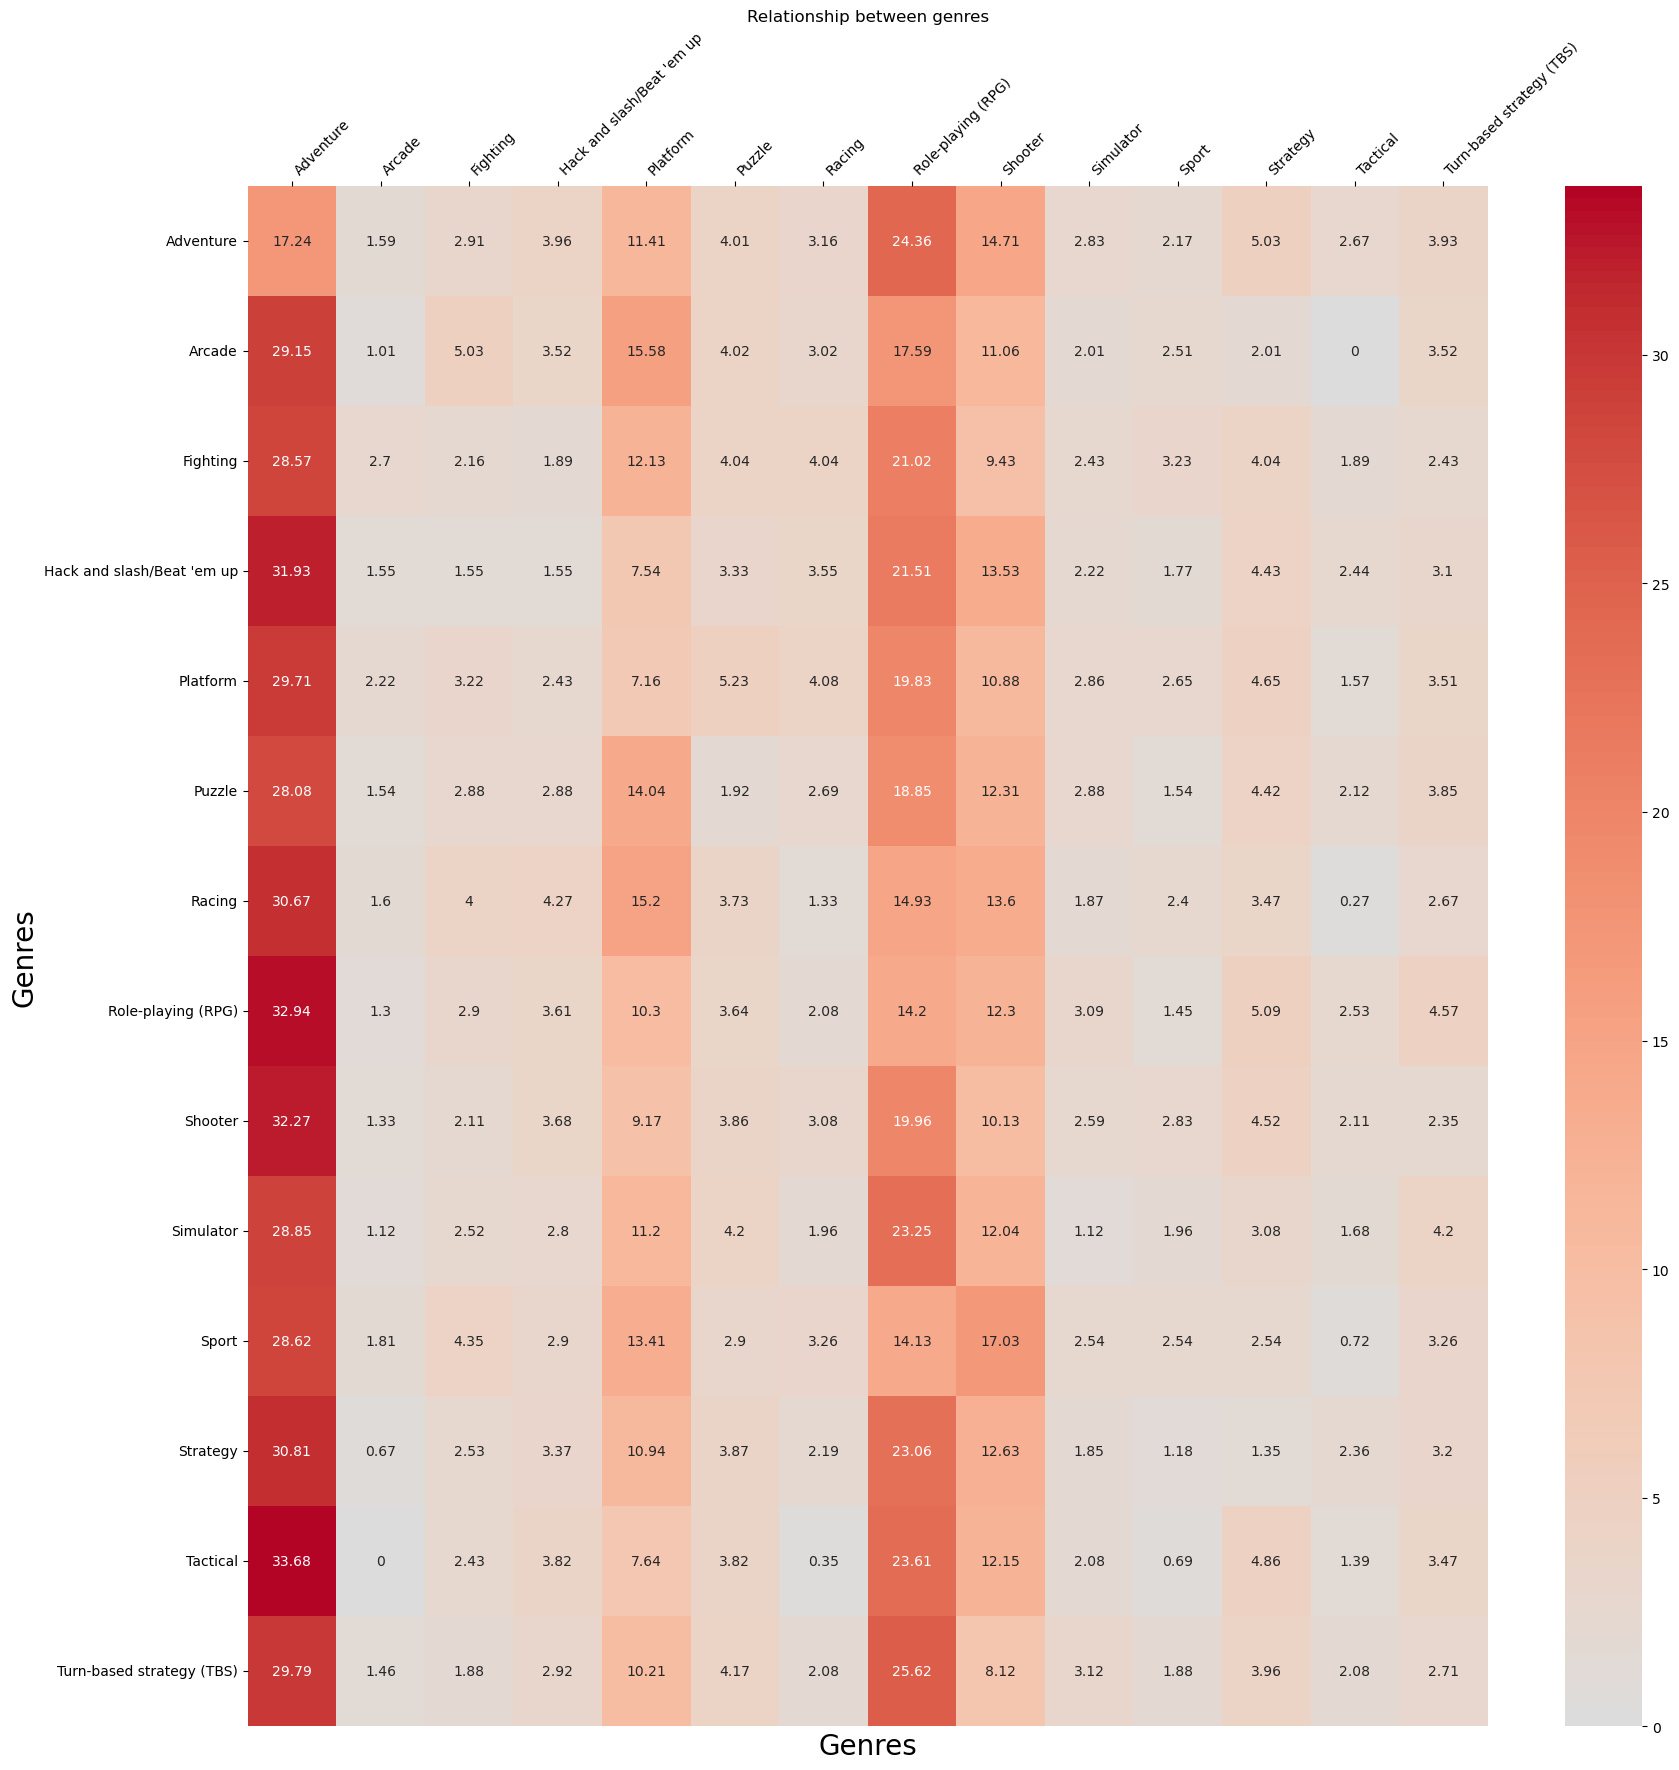

In [32]:
plot_relationship((relationship_confirmed_norm).round(2), 'confirmed_norm_filtered', genres_names=genres_names, have_wish=False,processed=True)

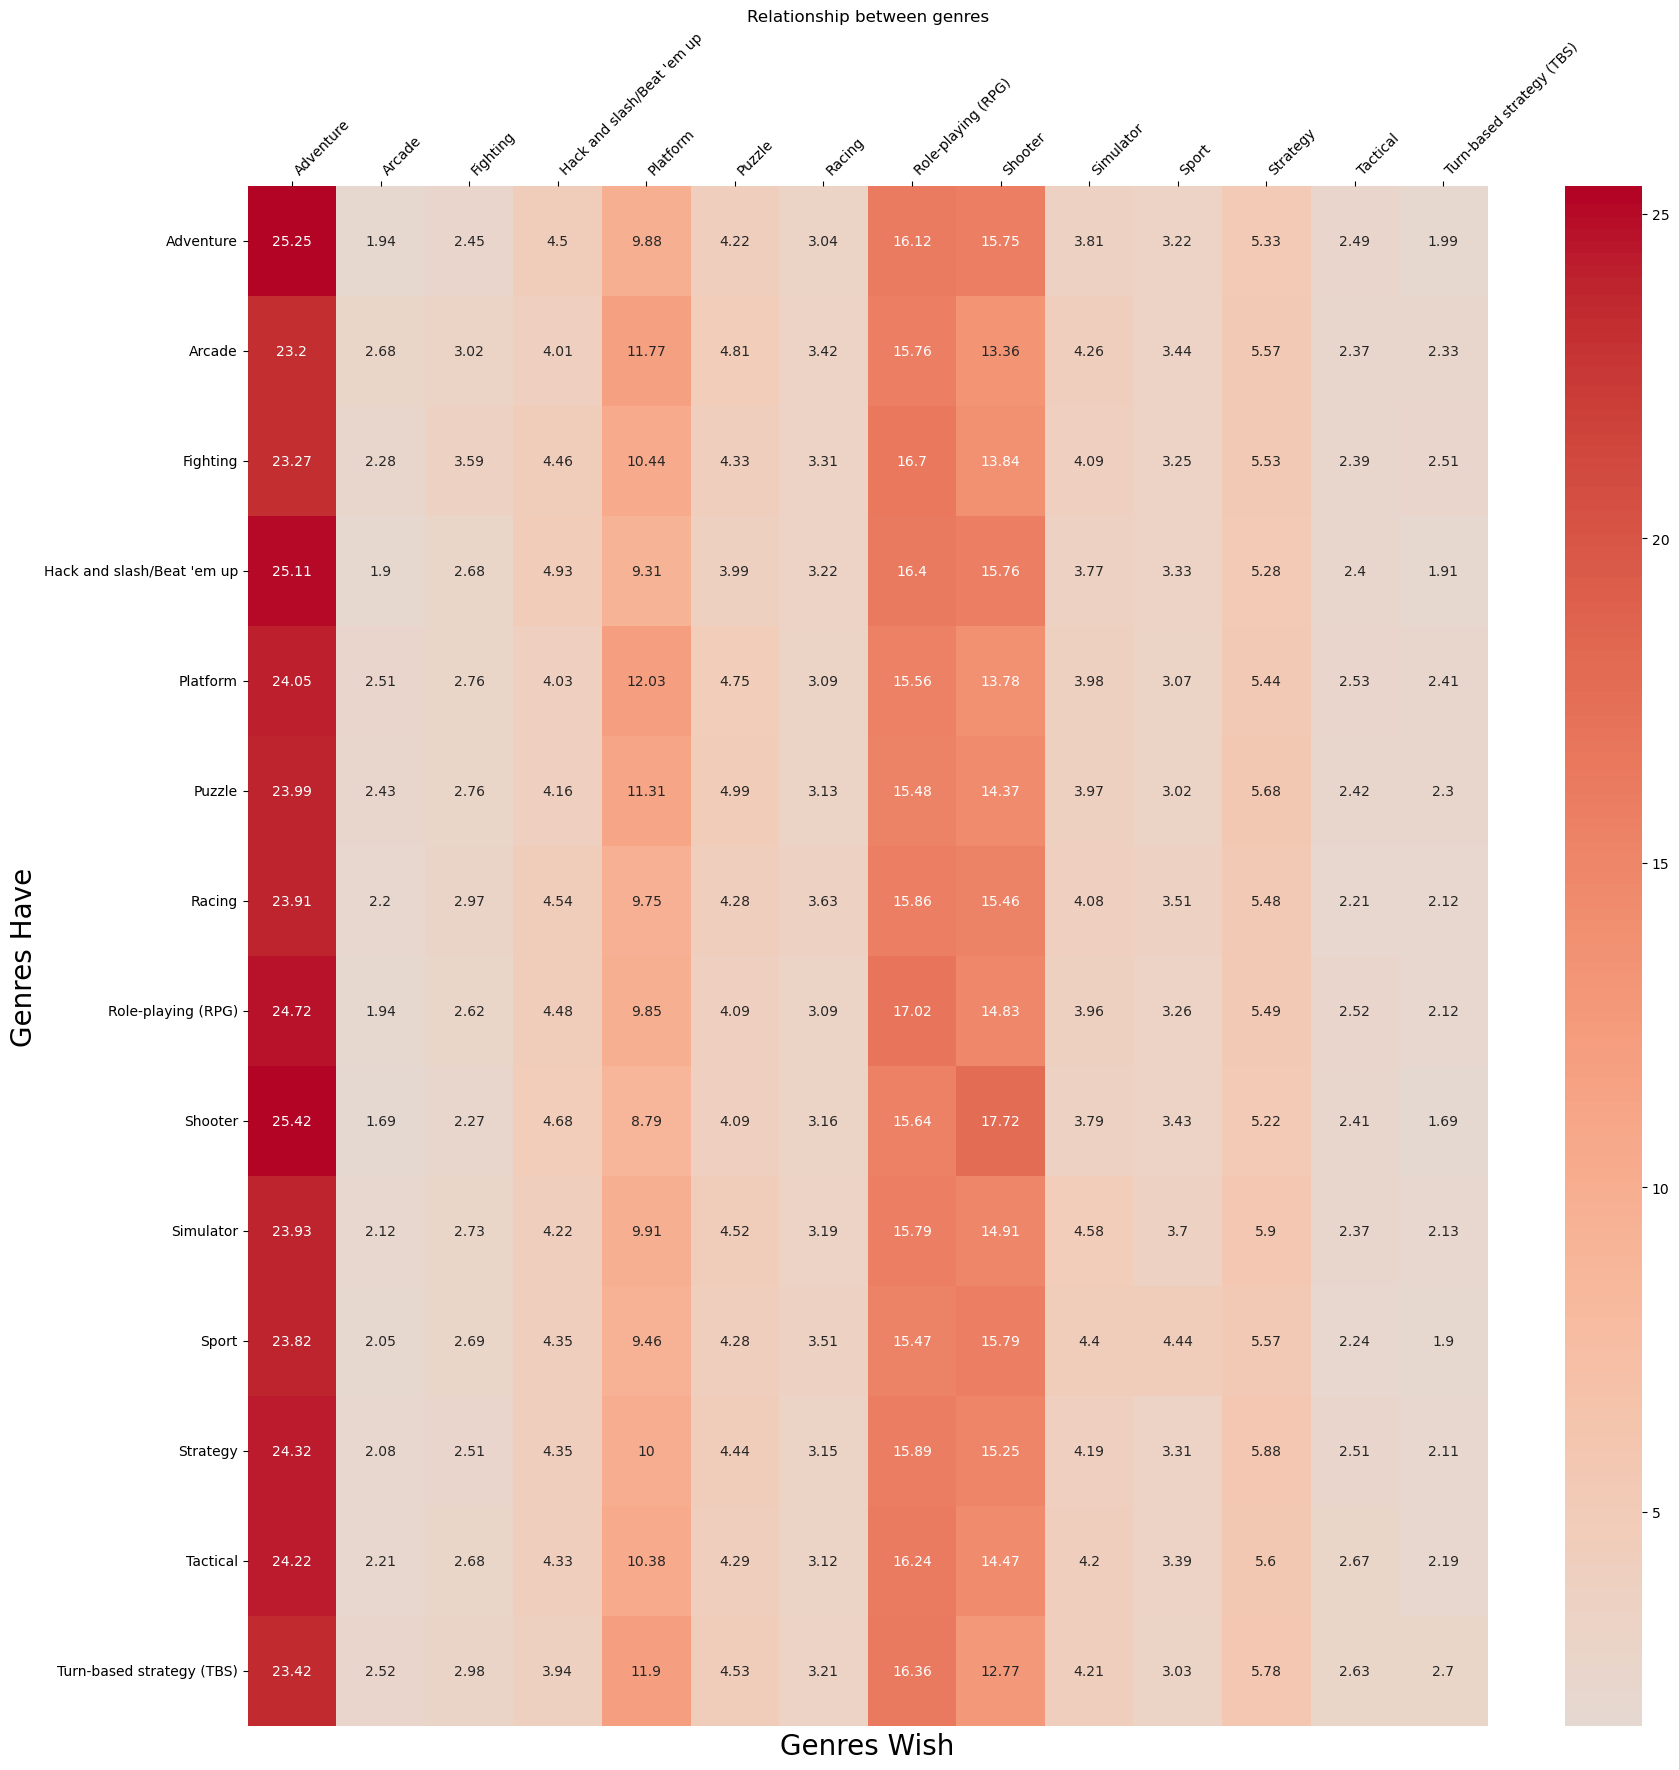

In [33]:
plot_relationship((relationship_have_wish_norm).round(2), 'have_wish_norm_filtered', genres_names=genres_names, have_wish=True,processed=True)

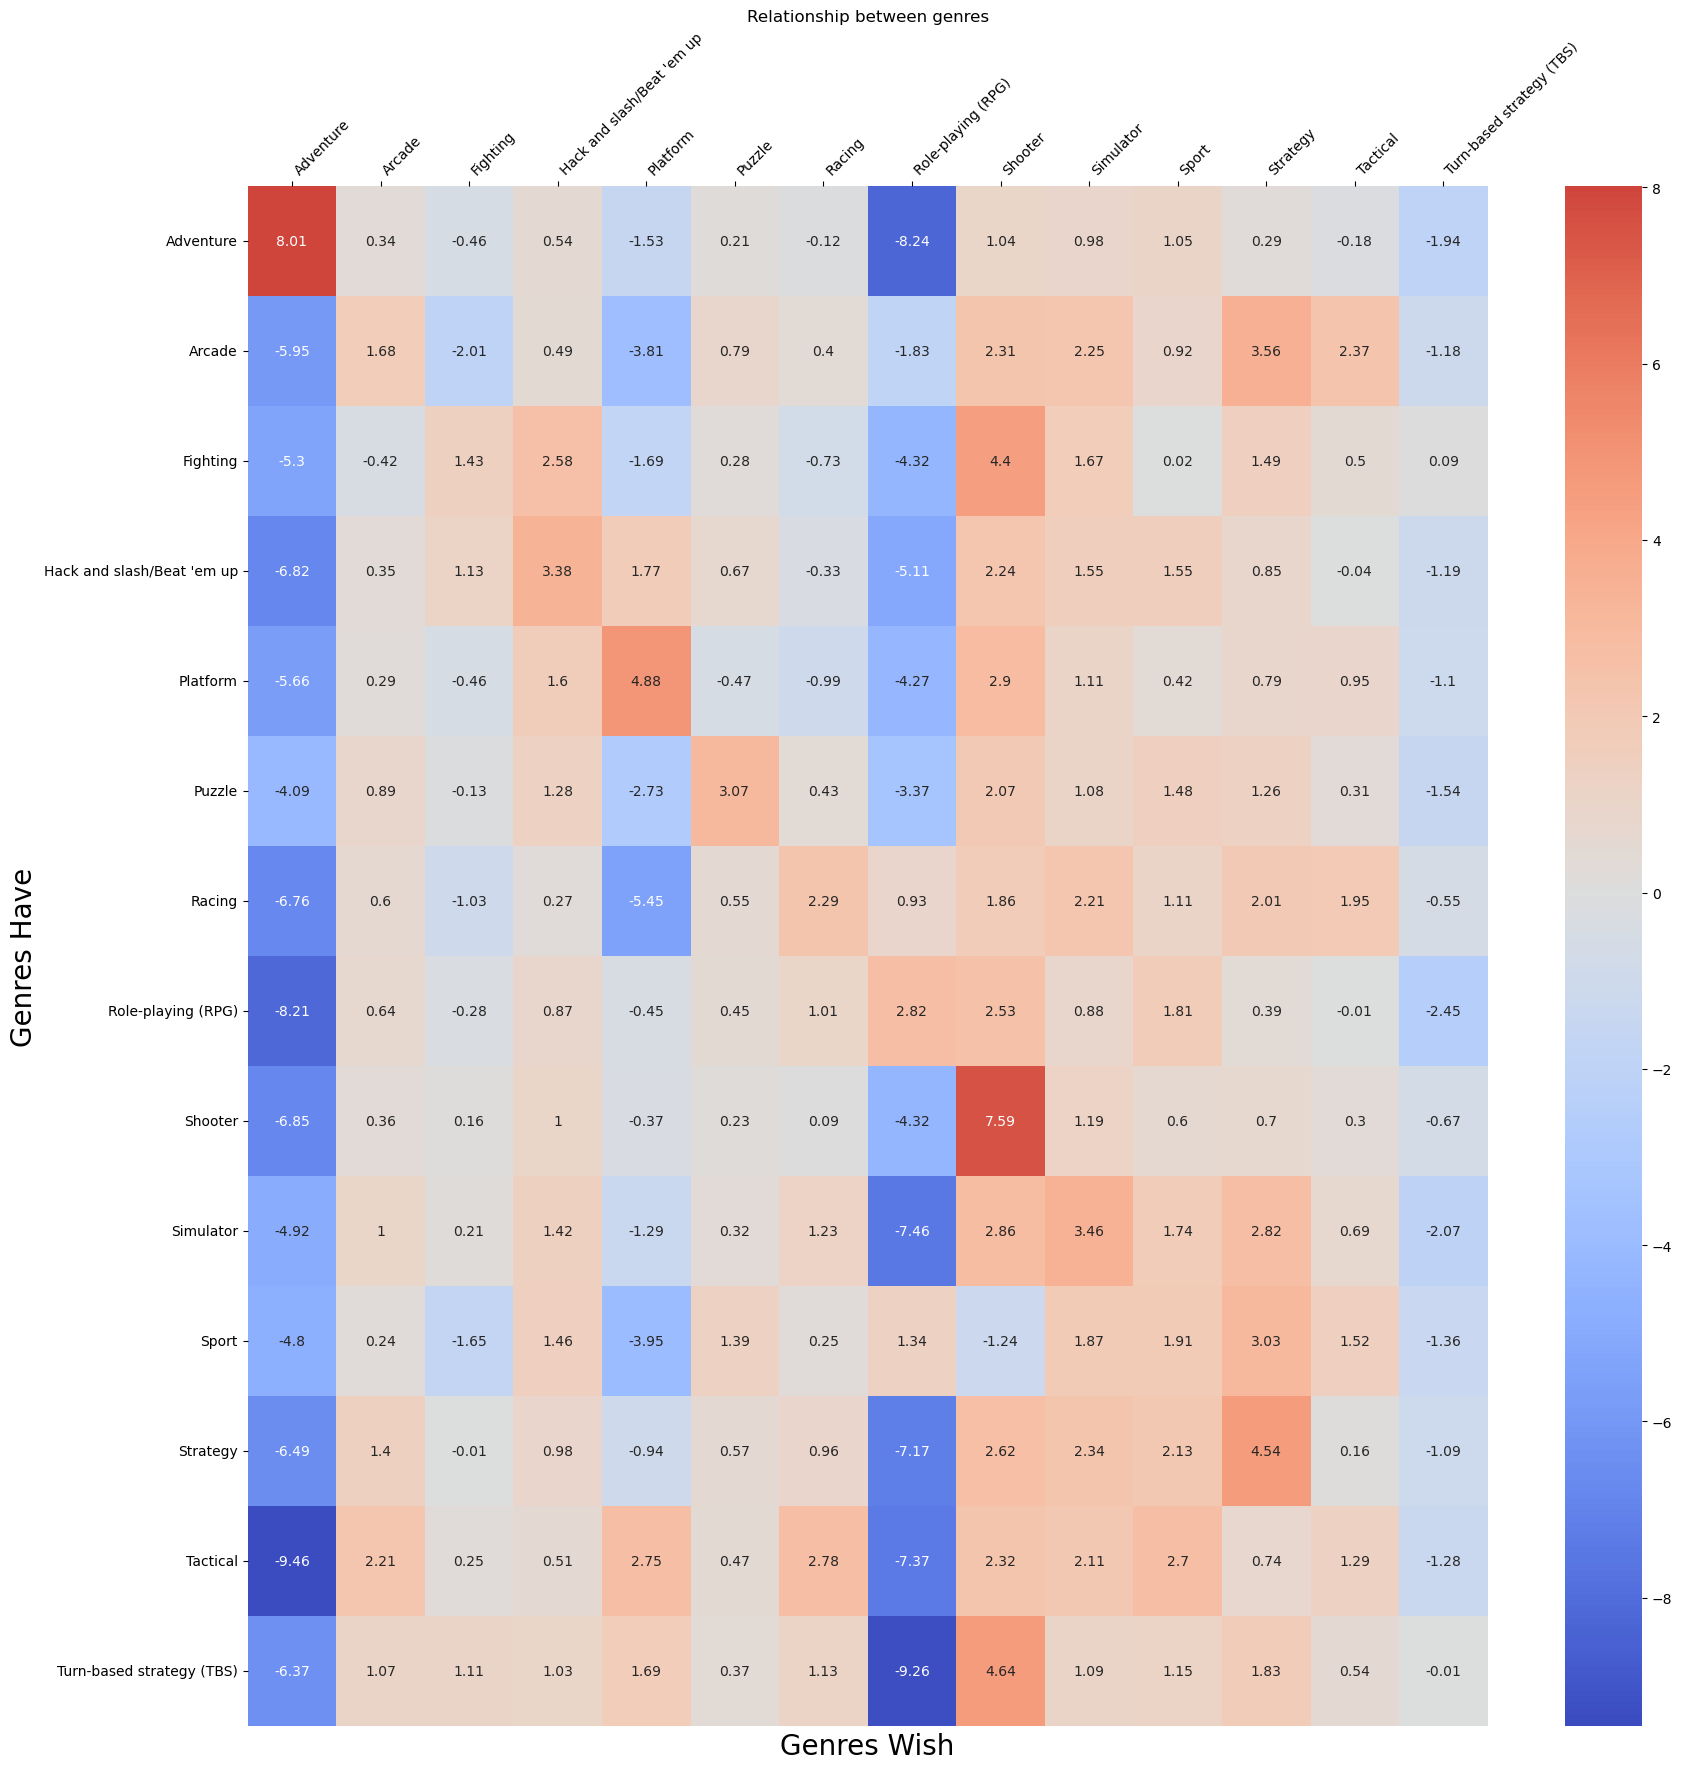

In [34]:
plot_relationship(relationship_diff_plot, 'diff', genres_names=games_genres, processed=True, have_wish=True)

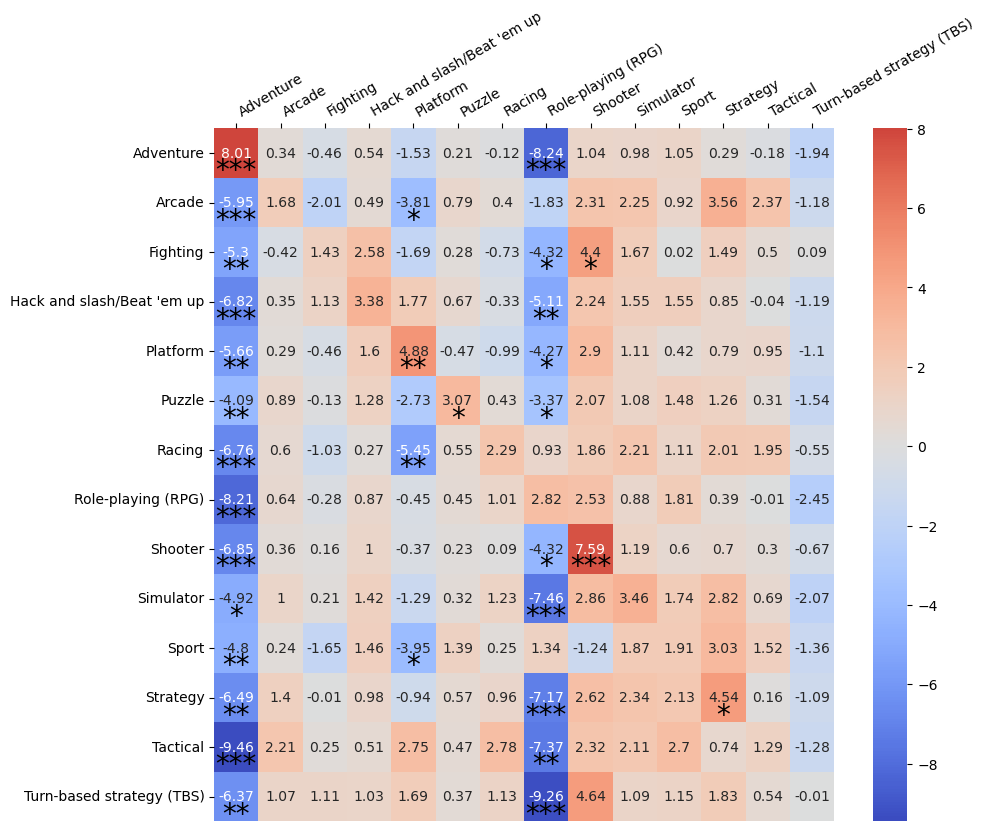

In [35]:
plot_relationship_with_t(relationship_diff_plot, 'diff_t', genres_names=games_genres,save=True)

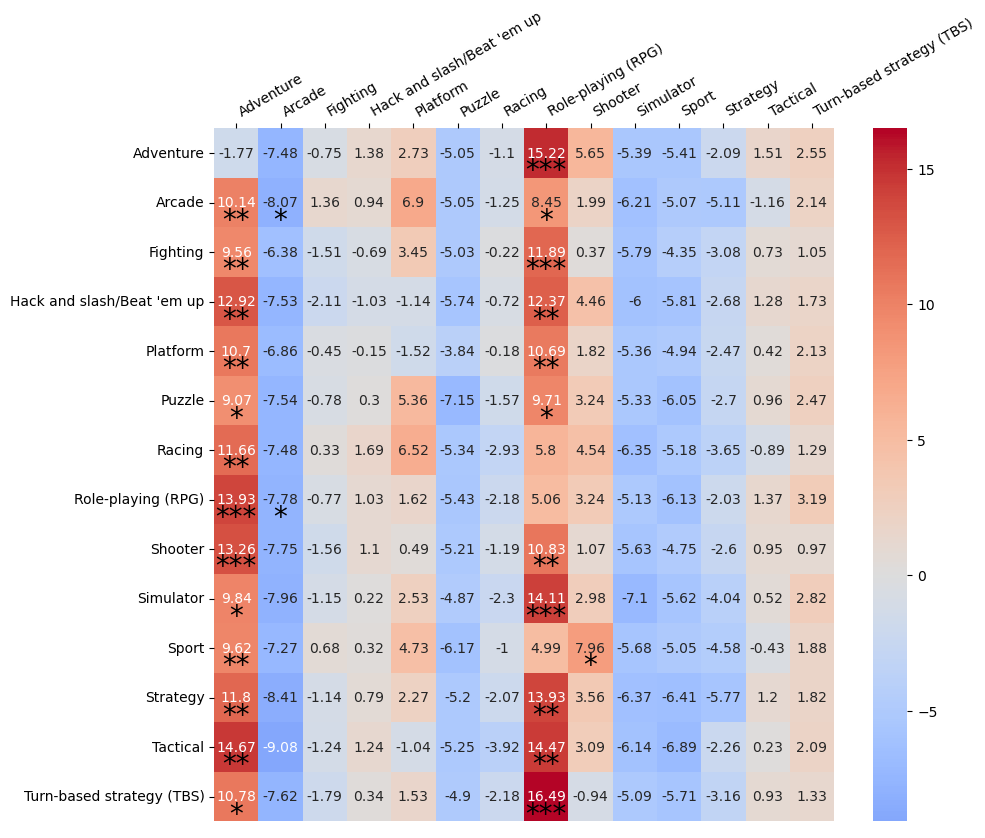

In [36]:
plot_relationship_with_t(relationship_confirmed_norm.apply(lambda x: x-df_console_genres_count['percent'].values, axis=1).round(2), 'confirmed_relationship_t_minus_base', genres_names=games_genres,save=True)